In [1]:
# In [1]: Imports and Setup
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adjust path as needed
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sbi import utils as sbi_utils
from sbi import inference as sbi_inference
from sbi.inference import SNPE, simulate_for_sbi
from multiplex_sim import Microscope, io, plotting

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# In [2]: Define the prior over emission peak (λ_max) and width (σ)
prior = sbi_utils.BoxUniform(low=torch.tensor([450.0, 10.0]), 
                             high=torch.tensor([650.0, 50.0]))

In [3]:

simulator = partial(
    Microscope.simulate_detected_signal,
    num_channels=3,
    center_wavelengths=[500.0, 550.0, 600.0],
    bandwidth=15.0
)

In [4]:
# In [3]: Wrap the simulator
simulator, prior = sbi_utils.user_input_checks.prepare_for_sbi(simulator, prior)

/tmp/ipykernel_1018433/1640293814.py:2: DeprecationWarning: This method is deprecated as of sbi version v0.23.0. and will be removed in a         future release.Please use `process_prior` and `process_simulator` in the future.
  simulator, prior = sbi_utils.user_input_checks.prepare_for_sbi(simulator, prior)
/groups/spruston/home/moharb/sbi-DELTA/multiplex_sim/Microscope.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(signals, dtype=torch.float32)


In [5]:
# In [4]: Generate training data via simulation
inference = sbi_inference.SNPE(prior)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 32960.35it/s]


 Neural network successfully converged after 364 epochs.

In [6]:
# Define true parameters for a fluorophore
true_params = torch.tensor([[575.0, 35.0]])  # shape: (1, 2)

# Define 3 narrow-band detection channels at these peak wavelengths:
center_wavelengths = [500.0, 550.0, 600.0]  # in nm
bandwidth = 15.0  # narrow filters

# Simulate the detected signal vector (1 value per channel)
x_observed = Microscope.simulate_detected_signal(
    params=true_params,
    num_channels=3,
    center_wavelengths=center_wavelengths,
    bandwidth=bandwidth
)

print(f"Simulated observations for {center_wavelengths} nm channels:")
print(x_observed)

Simulated observations for [500.0, 550.0, 600.0] nm channels:
tensor([[ 4.9680, 27.8591, 27.8591]])


In [7]:
print(posterior.posterior_estimator.condition_shape)
print(x_observed[0].shape)

torch.Size([3])
torch.Size([3])


In [8]:
# In [6]: Draw posterior samples conditioned on observed signal
samples = posterior.sample((10000,), x=x_observed[0])
samples_np = samples.numpy()

Drawing 10000 posterior samples: 10095it [00:00, 598009.98it/s]           


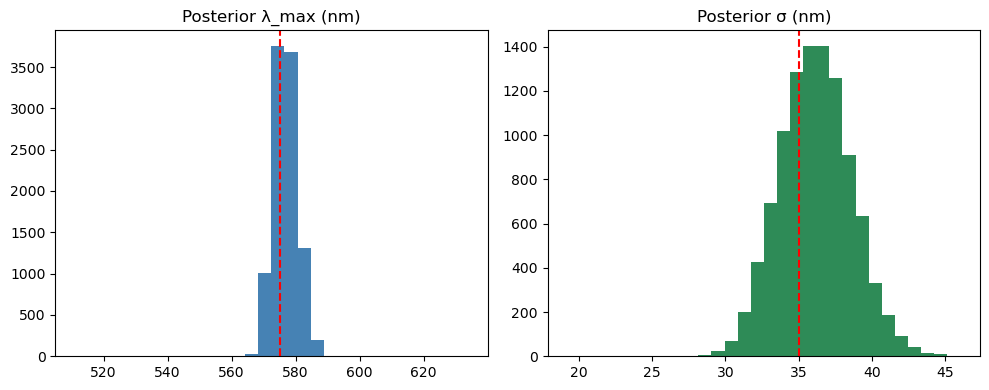

In [ ]:
# In [7]: Plot posterior samples
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(samples_np[:, 0], bins=30, color='steelblue')
ax[0].axvline(true_params[0, 0], color='red', linestyle='--')
ax[0].set_title("Posterior λ_max (nm)")

ax[1].hist(samples_np[:, 1], bins=30, color='seagreen')
ax[1].axvline(true_params[0, 1], color='red', linestyle='--')
ax[1].set_title("Posterior σ (nm)")

plt.tight_layout()
plt.show()



# load and save spectra

In [2]:
io.process_spectra_folder("../data/spectra/", out_folder="../data/spectra_npz")

[SAVED] AF488.npz
[SAVED] AF514.npz
[SAVED] AF532.npz
[SAVED] AF546.npz
[SAVED] AF555.npz
[SAVED] AF561.npz
[SAVED] AF594.npz
[SAVED] AF610.npz
[SAVED] AF633.npz
[SAVED] AF647.npz
[SAVED] JF479.npz
[SAVED] JF552.npz
[SAVED] JF608.npz
[SAVED] JF722.npz
[SAVED] JFX650.npz
[SAVED] JFX673.npz
[SAVED] NADH - .npz


In [2]:
from multiplex_sim import plotting

(400.0, 800.0)

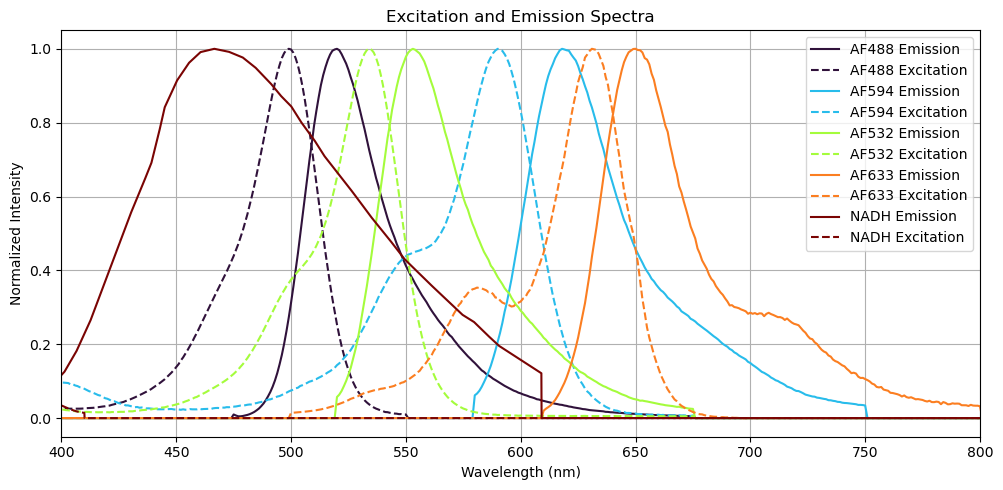

In [4]:
f = plotting.plot_fluorophores(names=['AF488','AF594','AF532', 'AF633', 'NADH'], npz_folder='../data/spectra_npz')
plt.xlim([400,800])

(400.0, 800.0)

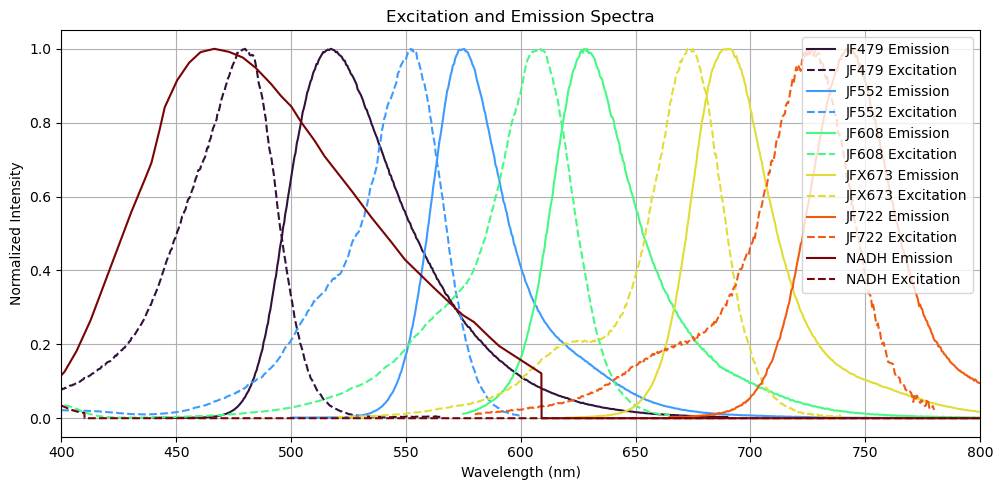

In [10]:
f = plotting.plot_fluorophores(names=['JF479','JF552','JF608','JFX673','JF722', 'NADH'], npz_folder='../data/spectra_npz')
plt.xlim([400,800])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def align_excitation_spectra(fluor_names, spectra_dir):
    spectra = {}
    min_wl = float('inf')
    max_wl = 0

    # First pass: determine global wavelength bounds
    for name in fluor_names:
        wl, ex = np.load(f"{spectra_dir}/{name}.npz")["wavelengths_excitation"], np.load(f"{spectra_dir}/{name}.npz")["excitation"]
        wl = wl.astype(float)
        ex = ex / np.max(ex)  # normalize
        spectra[name] = (wl, ex)
        min_wl = min(min_wl, wl.min())
        max_wl = max(max_wl, wl.max())

    # Create shared wavelength grid
    shared_wl = np.arange(int(min_wl), int(max_wl) + 1)
    aligned_matrix = {}

    for name, (wl, ex) in spectra.items():
        interp = interp1d(wl, ex, kind='linear', bounds_error=False, fill_value=0)
        aligned_matrix[name] = interp(shared_wl)

    return shared_wl, aligned_matrix

In [2]:
def find_optimal_excitation(fluor_names, spectra_dir):
    shared_wl, aligned_spectra = align_excitation_spectra(fluor_names, spectra_dir)
    optimal = {}

    for i, name in enumerate(fluor_names):
        contrast_score = []
        for λi in shared_wl:
            idx = np.searchsorted(shared_wl, λi)
            score = 0
            for j, other_name in enumerate(fluor_names):
                ex_val = aligned_spectra[other_name][idx]
                if j == i:
                    score += ex_val
                else:
                    score -= ex_val
            contrast_score.append(score)

        contrast_score = np.array(contrast_score)
        best_idx = np.argmax(contrast_score)
        best_wl = shared_wl[best_idx]
        optimal[name] = int(best_wl)

        # Plotting
        plt.figure(figsize=(10, 4))
        plt.plot(shared_wl, aligned_spectra[name], label='Excitation', color='gray')
        plt.plot(shared_wl, contrast_score, label='Contrast Score', color='blue')
        plt.axvline(best_wl, color='red', linestyle='--', label=f'Selected λ = {best_wl}')
        plt.title(f"{name} — Excitation vs Contrast Score")
        plt.xlabel("Wavelength (nm)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return optimal

In [3]:
optimal = find_optimal_excitation(['AF488','AF594','AF532', 'AF633', 'NADH'],'../data/spectra_npz')

KeyError: 'wavelength_nm is not a file in the archive'